In [64]:
import bioacoustics_model_zoo as bmz 
# The Bioacoustics Model Zoo holds publicly released models like HawkEars which can be operated through OpenSoundscape.
# For more information about other available models in the Model Zoo, visit: https://github.com/kitzeslab/bioacoustics-model-zoo/tree/main
from opensoundscape.annotations import BoxedAnnotations # Some useful functions from OpenSoundscape.
from opensoundscape import Audio, Spectrogram
from sklearn.manifold import TSNE # Clustering algorithm.
from matplotlib import pyplot as plt
import pandas as pd
from glob import glob

In [58]:
hawkears = bmz.HawkEars() # Load HawkEars.

Downloaded completed: hgnet1.ckpt
Loading model from local checkpoint /Users/laurenchronister/Desktop/aos_wksp/hgnet1.ckpt...
Downloaded completed: hgnet2.ckpt
Loading model from local checkpoint /Users/laurenchronister/Desktop/aos_wksp/hgnet2.ckpt...
Downloaded completed: hgnet3.ckpt
Loading model from local checkpoint /Users/laurenchronister/Desktop/aos_wksp/hgnet3.ckpt...
Downloaded completed: hgnet4.ckpt
Loading model from local checkpoint /Users/laurenchronister/Desktop/aos_wksp/hgnet4.ckpt...
Downloaded completed: hgnet5.ckpt
Loading model from local checkpoint /Users/laurenchronister/Desktop/aos_wksp/hgnet5.ckpt...


/Users/laurenchronister/miniconda3/envs/opso-0.12.0/lib/python3.10/site-packages/opensoundscape/preprocess/preprocessors.py:512: DeprecationWarning: sample_shape argument is deprecated. Please use height, width, channels arguments instead. 
                The current behavior is to override height, width, channels with sample_shape 
                when sample_shape is not None.
                
  warnings.warn(
/Users/laurenchronister/miniconda3/envs/opso-0.12.0/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:599: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to registe

In [71]:
# Gather the hooded warbler data.
annotation_list = glob('howa_xc_2021/annotations/*') # Annotations.
audio_list = [f"howa_xc_2021/audios/{txt.split('/')[-1].split('.')[0]}.mp3" for txt in annotation_list] # Corresponding audio.

annotations = BoxedAnnotations.from_raven_files(
    raven_files=annotation_list,
    audio_files=audio_list,
    annotation_column='label',
    keep_extra_columns=None
)

annotations = annotations.subset(['HOWA-song-A','HOWA-song-B']) # We'll focus on just the type A and type B songs.
print(annotations.df.annotation.value_counts())
annotations.df.head() # You can see that the annotations are now associated with their corresponding audio and annotation files
# in a dataframe.

annotation
HOWA-song-B    278
HOWA-song-A    200
Name: count, dtype: int64


,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f
0,howa_xc_2021/audios/232258.mp3,howa_xc_2021/annotations/232258.txt,HOWA-song-B,1.657125,3.081431,2392.4,4698.2
1,howa_xc_2021/audios/232258.mp3,howa_xc_2021/annotations/232258.txt,HOWA-song-B,8.970389,10.531647,2132.9,5851.2
2,howa_xc_2021/audios/232258.mp3,howa_xc_2021/annotations/232258.txt,HOWA-song-B,15.516718,17.064281,2219.4,5851.2
3,howa_xc_2021/audios/236016.mp3,howa_xc_2021/annotations/236016.txt,HOWA-song-A,1.497010,3.412592,2132.9,5764.7
4,howa_xc_2021/audios/236016.mp3,howa_xc_2021/annotations/236016.txt,HOWA-song-A,20.615342,22.250235,2017.6,6197.1


In [72]:
clip_len = 3 # HawkEars uses clips that are three seconds long, so we'll have to make these that length.
annotations = pd.DataFrame({'file':annotations.df['audio_file'].tolist(),
                            'start_time':annotations.df['start_time'].tolist(),
                            'end_time':annotations.df['end_time'].tolist(),
                            'annotation':annotations.df['annotation'].tolist()})

# Center and modify clip length.
annotations['start_time'] = [(annotations['end_time'].iat[i]-annotations['start_time'].iat[i])/2+annotations['start_time'].iat[i]-(clip_len/2) 
                                for i in range(len(annotations['start_time']))]
annotations['end_time'] = [s+clip_len for s in annotations['start_time']]

annotations = annotations.set_index(['file','start_time','end_time'])

annotations.head()

annotation
file                           start_time end_time              
howa_xc_2021/audios/232258.mp3 0.869278   3.869278   HOWA-song-B
                               8.251018   11.251018  HOWA-song-B
                               14.790500  17.790500  HOWA-song-B
howa_xc_2021/audios/236016.mp3 0.954801   3.954801   HOWA-song-A
                               19.932789  22.932789  HOWA-song-A

Hooded Warbler song type A/category I


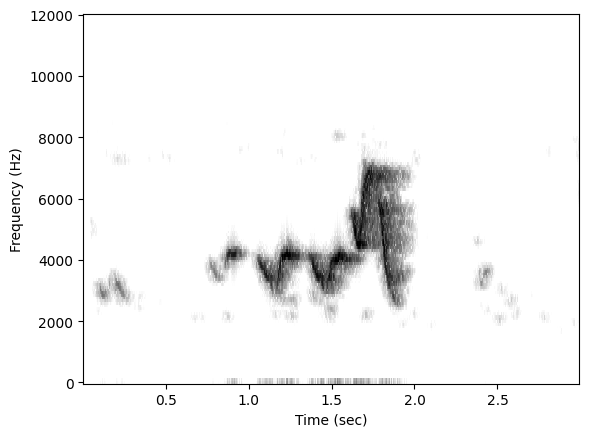

Hooded Warbler song type B/category II


/Users/laurenchronister/miniconda3/envs/opso-0.12.0/lib/python3.10/site-packages/opensoundscape/audio.py:1753: UserWarning: requested time period begins before start of recording
  warnings.warn(error_msg)


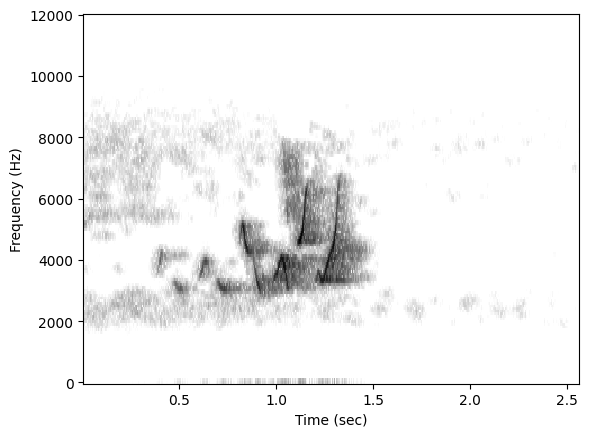

In [73]:
# Let's take a look at an example of both song types.
songA = annotations.loc[annotations['annotation']=='HOWA-song-A']
songA = songA.sample(n=1)
songB = annotations.loc[annotations['annotation']=='HOWA-song-B']
songB = songB.sample(n=1)
songA = Spectrogram.from_audio(Audio.from_file(songA.index[0][0], offset=songA.index[0][1], duration=clip_len))
songA = songA.bandpass(min_f=0, max_f=12000)
print('Hooded Warbler song type A/category I')
songA.plot()
songB = Spectrogram.from_audio(Audio.from_file(songB.index[0][0], offset=songB.index[0][1], duration=clip_len))
songB = songB.bandpass(min_f=0, max_f=12000)
print('Hooded Warbler song type B/category II')
songB.plot()

In [75]:
# Let's generate embeddings now.
embeddings = hawkears.embed(annotations)

  0%|          | 0/478 [00:00<?, ?it/s]

/Users/laurenchronister/miniconda3/envs/opso-0.12.0/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/laurenchronister/miniconda3/envs/opso-0.12.0/lib/python3.10/site-packages/opensoundscape/audio.py:1753: UserWarning: Audio object is shorter than requested duration: 2.6673491379310343 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/laurenchronister/miniconda3/envs/opso-0.12.0/lib/python3.10/site-packages/opensoundscape/audio.py:1753: UserWarning: requested time period begins before start of recording
  warnings.warn(error_msg)
/Users/laurenchronister/miniconda3/envs/opso-0.12.0/lib/python3.10/site-packages/opensoundscape/audio.py:1753: UserWarning: Audio object is shorter than requested duration: 2.497521551724138 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/laurenchronister/miniconda3/envs/opso-0.

In [76]:
tsne = TSNE(2).fit_transform(embeddings)
annotations['x'] = tsne[:,0]
annotations['y'] = tsne[:,1]

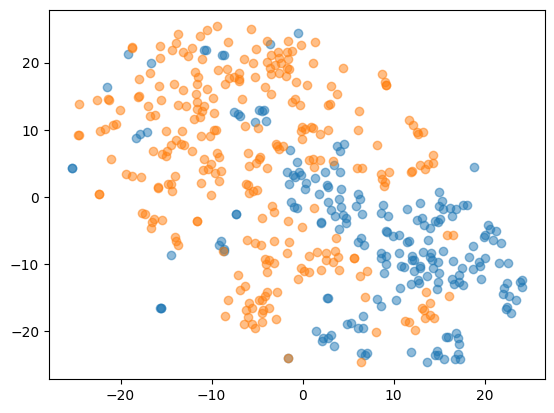

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111)
songA = annotations.loc[annotations['annotation']=='HOWA-song-A']
songB = annotations.loc[annotations['annotation']=='HOWA-song-B']
ax.scatter(songA['x'], songA['y'], alpha=0.5)
ax.scatter(songB['x'], songB['y'], alpha=0.5)